# Model 3 - CNN+RNN using both geo-spatial and kinematic features

In [2]:
%load_ext autoreload
%autoreload 2

import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sys.path.append('./dtu-deep-learning-project/src/')
from data_utils import *
clear_output(wait=False)

### Load train, validation and test data

In [3]:
user_train, user_val, user_test = train, val, test = train_test_data_split()

In [4]:
data_train = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_train]).reset_index(drop=True)
data_val = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_val]).reset_index(drop=True)
data_test = pd.concat([create_data_frame(*load_user_data(user), segmentation=True) for user in user_test]).reset_index(drop=True)

### Load precomputed image frames

In [5]:
image_data = {}
for user_id in user_train + user_val + user_test:
    with open(f'/mnt/array/valse_data/DeepLearning/Project/Pickle/images_list_{user_id}.pickle', 'rb') as f:
        image_data[user_id] = np.stack(pickle.load(f), axis = 0).astype(float)

#### Define Image Tensor Dataset

We implement our own Tensor Dataset in order to be able to do fast lookup of sequences and images.

In [6]:
class ImageTensorDataset(torch.utils.data.Dataset):

    def __init__(self, df, image_data):
        self.seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(5, -1, -1)], axis = 1)
        self.seq = self.seq[df['segment_ix'] >= 5]
        
        self.labels = df[df['segment_ix'] >= 5]['label'].values        
        self.user_id = df[df['segment_ix'] >= 5]['user'].values
        self.image_ix = df[df['segment_ix'] >= 5]['image_ix'].values        
        self.image_data = image_data
        tod = df[df['segment_ix'] >= 5]['tod'].values
        self.tod_one_hot = np.eye(5)[tod]
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, key):
        image = self.image_data[self.user_id[key]][self.image_ix[key]]
        return image, self.seq[key], self.tod_one_hot[key], self.labels[key]   

## Example Input/output data from ``TensorDataset``

In [7]:
demo_dataset = ImageTensorDataset(data_train, image_data)

for X_img, X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=3, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break;

X_img : torch.Size([3, 9, 9, 11])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
X_seq : torch.Size([3, 6, 2])
tensor([[ 1.2803, -2.9421],
        [ 0.8157, -2.6133],
        [ 1.3585, -2.7712],
        [ 1.1180, -2.7431],
        [ 0.8991, -2.6860],
        [ 1.0824, -2.6157]], dtype=torch.float64)
X_tod : torch.Size([3, 5])
tensor([0., 0., 0., 0., 1.], dtype=torch.float64)
y : torch.Size([3])
tensor(1)


### Hyper Parameters

In [225]:
# Network Parameters
IMG_INPUT_H_W = 9, 9
IMG_INPUT_C = 11
TOD_INPUT_DIM = 6
CNN_HIDDEN_DIM = 32
CNN_HIDDEN_DIM_2 = 16
CNN_KERNEL_SIZE = 3
CNN_PADDING = 0

SEQ_LENGTH = 6
SEQ_FEATURES = 2
TOD_INPUT_DIM = 5
RNN_HIDDEN_DIM = 4
RNN_NUM_LAYERS = 2
RNN_BIDIRECT = True
FC_HIDDEN_DIM = 512
DROPOUT_PROP = 0.45

NUM_CLASSES = 2

# Training Parameters
NUM_EPOCH = 100
BATCH_SIZE = 14000
LEARNING_RATE = 0.1
LEARNING_DECAY_FACTOR = 0.00001
LEARNING_DECAY_EPOCHS = [80]

#### Define Data Loaders

In [226]:
train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=False)

#### Define some utility functions for building and running the network

In [227]:
def adjust_lr(optimizer, epoch):
    number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
    lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

def conv2d_output_shape(h_w, kernel_size=1, stride=1, padding=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * padding) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * padding) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

### Define network for Convolutional neural network (CNN) using only geo-spatial features

In [228]:
class CnnNet(nn.Module):

    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.cnn_layer_1 = nn.Sequential(
            nn.Conv2d(IMG_INPUT_C, CNN_HIDDEN_DIM, kernel_size=CNN_KERNEL_SIZE, padding=CNN_PADDING),
            nn.BatchNorm2d(CNN_HIDDEN_DIM),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(DROPOUT_PROP)
        )
        
        h, w = IMG_INPUT_H_W
        #print(h, w)
        h, w = conv2d_output_shape((h, w), CNN_KERNEL_SIZE, padding=CNN_PADDING)
        #print(h, w)
        h, w = conv2d_output_shape((h, w), kernel_size=3, stride=2, padding=0)        
        #print(h, w)
        self.cnn_layer_2 = nn.Sequential(
            nn.Conv2d(CNN_HIDDEN_DIM, CNN_HIDDEN_DIM_2, kernel_size=CNN_KERNEL_SIZE, padding=CNN_PADDING),
            nn.BatchNorm2d(CNN_HIDDEN_DIM_2),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(DROPOUT_PROP)
        )
               
        h, w = conv2d_output_shape((h, w), CNN_KERNEL_SIZE, padding=CNN_PADDING)
        #print(h, w)
       # h, w = conv2d_output_shape((h, w), kernel_size=2, stride=2, padding=0)
        #print(h, w)
        
        rnn_output_dim = SEQ_LENGTH*RNN_HIDDEN_DIM
        if RNN_BIDIRECT:
            rnn_output_dim *= 2
        
        self.rnn_layer = nn.Sequential(
            nn.GRU(SEQ_FEATURES, RNN_HIDDEN_DIM, RNN_NUM_LAYERS, batch_first=True, bidirectional=RNN_BIDIRECT),
            SelectItem(0),
            nn.Flatten(start_dim=1),
            nn.BatchNorm1d(rnn_output_dim),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROP)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(CNN_HIDDEN_DIM_2 * h * w + TOD_INPUT_DIM + rnn_output_dim, FC_HIDDEN_DIM),
            nn.BatchNorm1d(FC_HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROP),
            nn.Linear(FC_HIDDEN_DIM, FC_HIDDEN_DIM//5),
            nn.BatchNorm1d(FC_HIDDEN_DIM//5),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROP),
            nn.Linear(FC_HIDDEN_DIM//5, NUM_CLASSES),
            #nn.BatchNorm1d(NUM_CLASSES),
            #nn.ReLU(),
            #nn.Dropout(DROPOUT_PROP)
        )
        #print(CNN_HIDDEN_DIM_2 * h * w + TOD_INPUT_DIM + rnn_output_dim)      

    def forward(self, X_img, X_seq, X_tod):
        X_img = X_img.permute(0, 3, 1, 2)
        #print(f'0     {X_img.shape}')
        out_img = self.cnn_layer_1(X_img)
        #print(f'1    {out_img.shape}')
        out_img = self.cnn_layer_2(out_img)
        #print(f'2    {out_img.shape}')
        out_img = out_img.reshape(out_img.size(0), -1)
        #print(f'3    {out_img.shape}')
        #print(f'4    {X_tod.shape}')
        #print(f'6    {X_seq.shape}')
        out_seq = self.rnn_layer(X_seq)
        #print(f'7    {out_seq.shape}')
        out = torch.cat([out_seq,out_img, X_tod], dim=1)
        out = self.fc_layer(out)
        return out

#### Define class weights due to large class im-balance

In [229]:
class_weights = [(data_train['label'] == 0).sum()/(data_train['label'] == x).sum() for x in range(NUM_CLASSES)]
class_weights

[1.0, 0.36125205657481785]

#### Define model, optimizer and loss

In [230]:
device = torch.device('cuda:1') # PyTorch v0.4.0
model = CnnNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).to(device))

#### Number of parameters

In [231]:
np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

98144

#### Test input/output of model

In [232]:
out = model(X_img.to(device, dtype=torch.float), X_seq.to(device, dtype=torch.float), X_tod.to(device, dtype=torch.float))
print(out.shape)

torch.Size([495, 2])


In [233]:
out[:2].cpu()

tensor([[ 0.3261, -0.1470],
        [-0.3594, -0.1225]], grad_fn=<CopyBackwards>)

In [234]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    },
    'test': {
        'dataloader': test_dataloader,
        'is_training': False,
    }
}

### Train / Validation loop

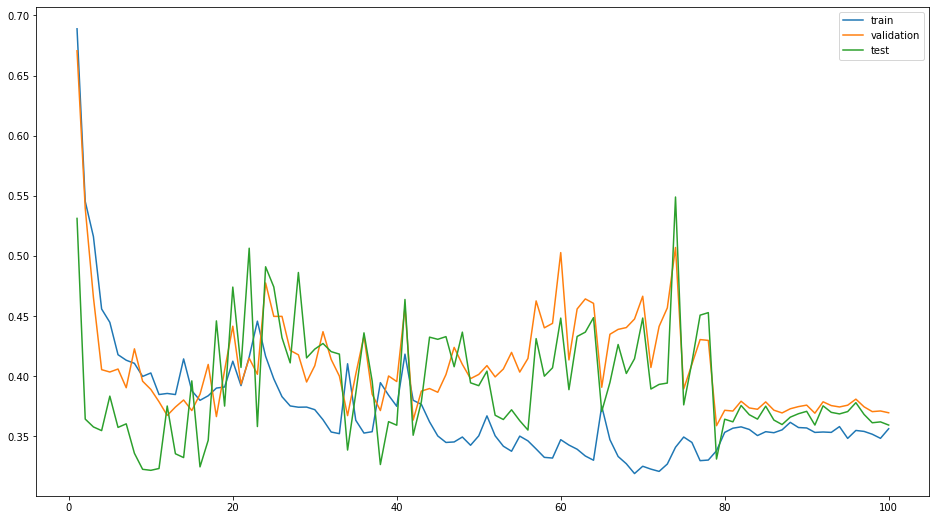

In [235]:
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            #print(i)
            #print(batch[0].shape)
            X_img, X_seq, X_tod, y = batch
            

            X_img = X_img.to(device, dtype=torch.float)
            X_seq = X_seq.to(device, dtype=torch.float)
            X_tod = X_tod.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.int64)

            with torch.set_grad_enabled(phase_is_training):
                out = model(X_img, X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.5)
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();            

### Validation/Test prediction loop

In [236]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_seq, X_tod, y = batch

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.to(device, dtype=torch.float)
        X_seq = X_seq.to(device, dtype=torch.float)
        X_tod = X_tod.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))        

### Final results

In [237]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop']))

validation
              precision    recall  f1-score   support

      Motion       0.70      0.91      0.79     43324
        Stop       0.93      0.77      0.84     72617

    accuracy                           0.82    115941
   macro avg       0.82      0.84      0.82    115941
weighted avg       0.85      0.82      0.82    115941

test
              precision    recall  f1-score   support

      Motion       0.68      0.90      0.77     42471
        Stop       0.96      0.86      0.91    126024

    accuracy                           0.87    168495
   macro avg       0.82      0.88      0.84    168495
weighted avg       0.89      0.87      0.87    168495

